# UCSQ & Efficiency: Trees and Topics

Two complementary paths for correlation analysis:
- Gradient Boosting on bag-of-words + numeric features to inspect `feature_importances_` for UCQS and Efficiency.
- Topic modeling (NMF) and correlations between topic weights and the metrics.

Now with text cleaning (URLs stripped, lowercasing, token pattern `a-z` length ≥3, multilingual stopwords) to reduce noise from articles, URLs, and service words.

## Setup
Libraries for data prep, TF-IDF, tree/boosting models, NMF topics, and n-gram correlations. Includes regex + multilingual stopword config for cleaning.

In [1]:
import re
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import NMF
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', 120)

# Cleaning helpers
URL_RE = re.compile('https?://\S+|www\.\S+')
EXTRA_STOPWORDS = {
    # English service/common
    'com', 'http', 'https', 'www', 'reddit', 'np', 'savevideo', 'info', 'wiki', 'discord',
    'ukrainianconflict', 'context', 'message', 'moderators', 'policy',
    # German
    'und', 'die', 'der', 'das', 'nicht', 'ist', 'für', 'den', 'ein', 'eine', 'sich', 'im', 'in', 'mit', 'auf', 'als',
    # Polish
    'nie', 'ja', 'ze', 'że', 'się', 'na', 'jest', 'to', 'z', 'do', 'o', 'po', 'jak', 'ale', 'także', 'tak',
    # French
    'le', 'la', 'les', 'des', 'un', 'une', 'et', 'pour', 'que', 'qui', 'dans', 'du',
    # Spanish
    'el', 'la', 'los', 'las', 'un', 'una', 'y', 'de', 'en', 'por', 'para', 'que',
    # Italian
    'il', 'lo', 'la', 'gli', 'le', 'uno', 'una', 'e', 'per', 'che', 'del', 'della', 'dei', 'degli',
    # Finnish/Scandinavian noise spotted
    'ett', 'että', 'och', 'det', 'som', 'han', 'hon', 'för', 'på', 'med',
}
STOPWORDS = sorted(ENGLISH_STOP_WORDS.union(EXTRA_STOPWORDS))

def clean_text(text: str) -> str:
    text = text.lower()
    text = URL_RE.sub(' ', text)
    return text


<>:21: SyntaxWarning: invalid escape sequence '\S'
<>:21: SyntaxWarning: invalid escape sequence '\S'
/var/folders/ks/d6pwjtjd5y7_9mmxkttk6rd00000gn/T/ipykernel_76765/2003844829.py:21: SyntaxWarning: invalid escape sequence '\S'
  URL_RE = re.compile('https?://\S+|www\.\S+')


## Load data
Read `reddit_metrics.csv`, build a unified text field, clean it (lowercase, strip URLs), and derive simple numeric features (length, word count, posting time).

In [2]:
DATA_PATH = Path('../data/reddit_metrics.csv')
assert DATA_PATH.exists(), f'Not found: {DATA_PATH}'

df = pd.read_csv(DATA_PATH)

# Unified raw text: title + selftext + comments_content
text_cols = ['title', 'selftext', 'comments_content']
df['text_raw'] = df[text_cols].fillna('').agg(' '.join, axis=1)

# Cleaned text used for modeling
df['text'] = df['text_raw'].map(clean_text)

# Posting time (expects ISO-like with timezone)
post_dt = pd.to_datetime(df['post_created_at'], errors='coerce')
df['hour'] = post_dt.dt.hour
df['dow'] = post_dt.dt.dayofweek

# Simple text stats based on cleaned text
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

base_features = ['post_score', 'num_comments', 'upvote_ratio', 'hour', 'dow', 'text_len', 'word_count']

print('Rows:', len(df))
df[base_features + ['UCQS', 'Efficiency']].describe()


Rows: 3702


,post_score,num_comments,upvote_ratio,hour,dow,text_len,word_count,UCQS,Efficiency
count,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000
mean,603.871961,28.849811,0.915346,13.874932,3.010535,5555.445705,890.346840,40.901625,4.158382
std,2393.180313,89.273138,0.154234,6.610667,2.030076,17035.046709,2793.287976,14.981282,2.238457
min,0.000000,0.000000,0.050000,0.000000,0.000000,21.000000,2.000000,0.000000,0.000000
25%,10.000000,1.000000,0.920000,10.000000,1.000000,93.000000,14.000000,29.731209,2.260000
50%,86.000000,4.000000,0.970000,15.000000,3.000000,550.500000,86.000000,50.000000,4.410000
75%,352.000000,19.000000,0.990000,19.000000,5.000000,2579.250000,389.000000,50.000000,5.790000
max,57537.000000,1553.000000,1.000000,23.000000,6.000000,240025.000000,37047.000000,86.551741,10.240000


## Bag-of-words (TF-IDF) for trees
Cleaning + token pattern to drop URLs/short tokens; multilingual stopwords to suppress service words. Vocabulary kept limited for interpretability.

In [3]:
tfidf = TfidfVectorizer(
    stop_words=STOPWORDS,
    min_df=5,
    max_features=800,
    token_pattern=r'[a-z]{3,}',
)
text_matrix = tfidf.fit_transform(df['text']).toarray()
text_feature_names = [f'w:{t}' for t in tfidf.get_feature_names_out()]

text_df = pd.DataFrame(text_matrix, columns=text_feature_names)
X_all = pd.concat([df[base_features].reset_index(drop=True), text_df], axis=1)

print('Feature matrix shape:', X_all.shape)


Feature matrix shape: (3702, 807)


## Gradient Boosting: training and feature importances
Train separate models for UCQS and Efficiency. Report R2/RMSE and top features by importance. For Efficiency, drop engagement metrics (`post_score`, `num_comments`, `upvote_ratio`) from the feature set.

In [4]:
DROP_FOR_EFF = ['post_score', 'num_comments', 'upvote_ratio']

def get_features_for(target: str):
    if target.lower() == 'efficiency':
        cols_to_drop = [c for c in DROP_FOR_EFF if c in X_all.columns]
        return X_all.drop(columns=cols_to_drop)
    return X_all

def train_and_inspect(target_col: str, top_n: int = 15, test_size: float = 0.2, random_state: int = 42):
    y = df[target_col]
    X = get_features_for(target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        random_state=random_state,
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    try:
        rmse = mean_squared_error(y_test, preds, squared=False)
    except TypeError:
        rmse = mean_squared_error(y_test, preds) ** 0.5
    print(f'{target_col}: R2={r2:.3f} | RMSE={rmse:.3f}')

    importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_feats = importances.head(top_n)
    display(top_feats)

    # Plot top importances
    top_feats.iloc[::-1].plot(kind='barh', figsize=(6, 4), title=f'Top {top_n} features for {target_col}')
    plt.tight_layout()
    plt.show()
    return model, importances


### UCQS model

UCQS: R2=0.583 | RMSE=9.646


w:don           0.214494
w:removed       0.150190
w:community     0.100849
text_len        0.075941
word_count      0.043084
w:putin         0.012529
w:trump         0.011697
w:shit          0.011604
num_comments    0.009447
w:vital         0.007804
w:support       0.006457
w:forget        0.006431
w:propaganda    0.006062
w:wait          0.005855
w:death         0.005749
dtype: float64

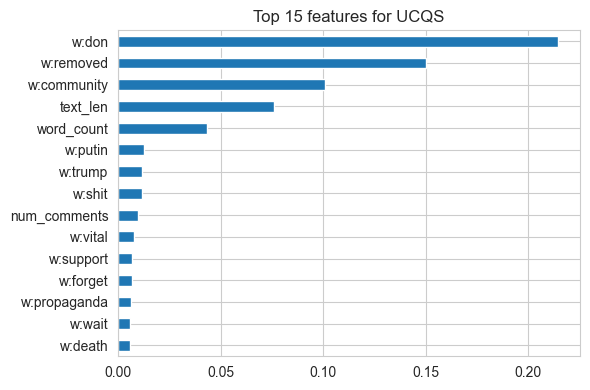

In [5]:
model_ucqs, importances_ucqs = train_and_inspect('UCQS', top_n=15)


### Efficiency model (engagement metrics removed)

Efficiency: R2=0.222 | RMSE=2.041


w:removed       0.057412
text_len        0.057062
w:yeah          0.046789
w:russian       0.046228
w:submission    0.030426
w:ukraine       0.028339
word_count      0.028089
w:questions     0.026686
w:russia        0.020134
w:peace         0.017739
w:zelenskyy     0.017233
w:post          0.017103
w:drone         0.012702
w:soldiers      0.012100
w:slava         0.010455
dtype: float64

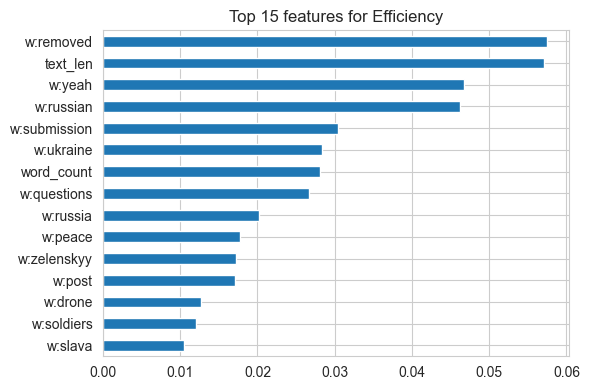

In [6]:
model_eff, importances_eff = train_and_inspect('Efficiency', top_n=15)


## Topic modeling (NMF) + correlations with UCQS/Efficiency
Uses the same cleaning and stopwords, larger vocab. Topics are easier to interpret than hundreds of words.

In [7]:
topic_vectorizer = TfidfVectorizer(
    stop_words=STOPWORDS,
    min_df=5,
    max_features=3000,
    token_pattern=r'[a-z]{3,}',
)
topic_matrix = topic_vectorizer.fit_transform(df['text'])

n_topics = 8
nmf = NMF(n_components=n_topics, init='nndsvda', random_state=42, max_iter=300)
W = nmf.fit_transform(topic_matrix)
H = nmf.components_
feature_names = topic_vectorizer.get_feature_names_out()


### Topic descriptions
Top words per topic for quick interpretability.

In [8]:
def describe_topics(H, feature_names, top_n=8):
    topics = []
    for i, topic_vec in enumerate(H):
        top_ids = topic_vec.argsort()[::-1][:top_n]
        top_terms = [feature_names[j] for j in top_ids]
        topics.append((i, top_terms))
    return topics

for idx, terms in describe_topics(H, feature_names, top_n=8):
    print(f'Topic {idx}: ' + ', '.join(terms))


Topic 0: ukraine, support, content, vital, vetted, charities, sunrise, actionforukraine
Topic 1: rules, unreliable, comments, post, violators, stereotyping, slogans, bigotry
Topic 2: russia, war, just, like, people, don, think, country
Topic 3: downloader, video, bot, removed, npaging, combatfootage, guidelines, section
Topic 4: ukrainian, russian, drone, brigade, drones, june, fpv, region
Topic 5: trump, putin, peace, zelensky, ukraine, zelenskyy, meeting, president
Topic 6: ukraine, russia, aid, nato, military, defense, russian, says
Topic 7: europe, thank, nplease, link, worldnews, removed, post, submission


### Topic correlations with metrics
Correlations of topic weights with UCQS and Efficiency (top/bottom 5).

In [9]:
W_df = pd.DataFrame(W, columns=[f'topic_{i}' for i in range(n_topics)])
correlations = pd.DataFrame(
    {
        'UCQS_corr': W_df.corrwith(df['UCQS']),
        'Efficiency_corr': W_df.corrwith(df['Efficiency']),
    }
)

ucqs_sorted = correlations.sort_values('UCQS_corr')
eff_sorted = correlations.sort_values('Efficiency_corr')

print('UCQS correlations (lowest 5):')
display(ucqs_sorted.head(5))
print('UCQS correlations (highest 5):')
display(ucqs_sorted.tail(5))

print('Efficiency correlations (lowest 5):')
display(eff_sorted.head(5))
print('Efficiency correlations (highest 5):')
display(eff_sorted.tail(5))


UCQS correlations (lowest 5):


,UCQS_corr,Efficiency_corr
topic_1,-0.468627,-0.128433
topic_2,-0.411233,0.288258
topic_5,-0.213091,0.023362
topic_7,-0.074271,-0.120633
topic_3,0.021125,0.071537


UCQS correlations (highest 5):


,UCQS_corr,Efficiency_corr
topic_7,-0.074271,-0.120633
topic_3,0.021125,0.071537
topic_6,0.087312,0.089850
topic_0,0.139305,0.045563
topic_4,0.185179,0.147095


Efficiency correlations (lowest 5):


,UCQS_corr,Efficiency_corr
topic_1,-0.468627,-0.128433
topic_7,-0.074271,-0.120633
topic_5,-0.213091,0.023362
topic_0,0.139305,0.045563
topic_3,0.021125,0.071537


Efficiency correlations (highest 5):


,UCQS_corr,Efficiency_corr
topic_0,0.139305,0.045563
topic_3,0.021125,0.071537
topic_6,0.087312,0.089850
topic_4,0.185179,0.147095
topic_2,-0.411233,0.288258


## N-gram correlations (up to 7-grams)
Spearman correlations between each n-gram (1–7) and UCQS/Efficiency. Vocabulary is capped to keep runtime reasonable.

In [10]:
ngram_vectorizer = TfidfVectorizer(
    stop_words=STOPWORDS,
    min_df=5,
    max_features=5000,
    token_pattern=r'[a-z]{3,}',
    ngram_range=(1, 7),
)
ngram_matrix = ngram_vectorizer.fit_transform(df['text'])
ngram_features = ngram_vectorizer.get_feature_names_out()
print('N-gram matrix shape:', ngram_matrix.shape)

def corr_top(matrix, names, target, top=15):
    corrs = []
    y = df[target].values
    for j in range(matrix.shape[1]):
        col = matrix[:, j].toarray().ravel()
        if col.sum() == 0:
            continue
        rho, _ = spearmanr(col, y)
        if np.isnan(rho):
            continue
        corrs.append((names[j], rho))
    corr_df = pd.DataFrame(corrs, columns=['ngram', 'spearman']).sort_values('spearman')
    print(f'{target}: computed correlations for {len(corr_df)} n-grams')
    print('Lowest correlations:')
    display(corr_df.head(top))
    print('Highest correlations:')
    display(corr_df.tail(top))
    return corr_df

corr_ucqs = corr_top(ngram_matrix, ngram_features, 'UCQS', top=15)
corr_eff = corr_top(ngram_matrix, ngram_features, 'Efficiency', top=15)


N-gram matrix shape: (3702, 5000)
UCQS: computed correlations for 5000 n-grams
Lowest correlations:


,ngram,spearman
3478,removed,-0.632456
1114,don,-0.583463
2236,like,-0.579208
2120,know,-0.535188
4335,time,-0.534727
3373,read,-0.533153
2212,let,-0.521656
3784,send,-0.514387
3110,post,-0.509524
1534,forget,-0.505986


Highest correlations:


,ngram,spearman
4602,united media wartime,-0.005247
2430,media wartime community focused vital high effort,-0.005247
3440,regiment,-0.003918
1148,donetsk region,-0.003868
2021,javelin,-0.003287
2417,mechanized,-0.001658
1761,hello,0.001113
397,bombers,0.002097
4450,turret,0.006877
452,brigade,0.006920


Efficiency: computed correlations for 5000 n-grams
Lowest correlations:


,ngram,spearman
4094,submission,-0.135529
4115,subreddit compose questions concerns time read rules,-0.128337
732,compose questions concerns time read,-0.128337
734,compose questions concerns time read rules rules,-0.128337
751,concerns time read rules rules trolls bots,-0.128337
750,concerns time read rules rules trolls,-0.128337
3323,questions concerns time read,-0.128337
749,concerns time read rules rules,-0.128337
3324,questions concerns time read rules,-0.128337
3325,questions concerns time read rules rules,-0.128337


Highest correlations:


,ngram,spearman
4830,way,0.224579
4965,yes,0.225800
2330,lot,0.227678
1997,isn,0.228111
1653,going,0.228152
1576,fuck,0.230191
2309,lol,0.231794
1660,good,0.233058
3691,russians,0.233239
2064,just,0.233336


## Plot: top n-grams by |Spearman| (UCQS)
Horizontal bar chart of the 15 n-grams with the largest absolute Spearman correlation to UCQS.

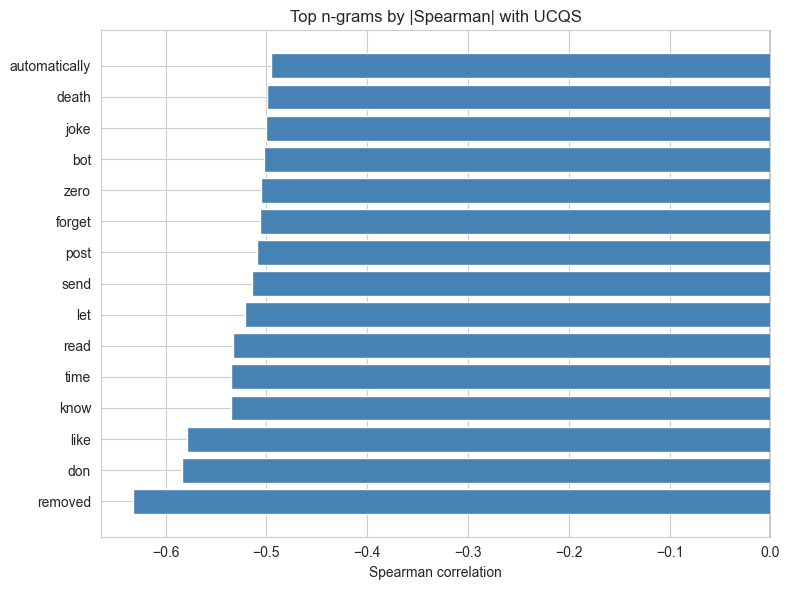

In [11]:
top_ucqs = corr_ucqs.assign(abs_corr=lambda d: d.spearman.abs()).sort_values('abs_corr', ascending=False).head(15)
plt.figure(figsize=(8, 6))
ordered = top_ucqs.sort_values('spearman')
plt.barh(ordered['ngram'], ordered['spearman'], color='steelblue')
plt.axvline(0, color='black', linewidth=1)
plt.title('Top n-grams by |Spearman| with UCQS')
plt.xlabel('Spearman correlation')
plt.tight_layout()
plt.show()


## Heatmap: topic correlations with UCQS/Efficiency
Quick view of how each topic correlates with both metrics.

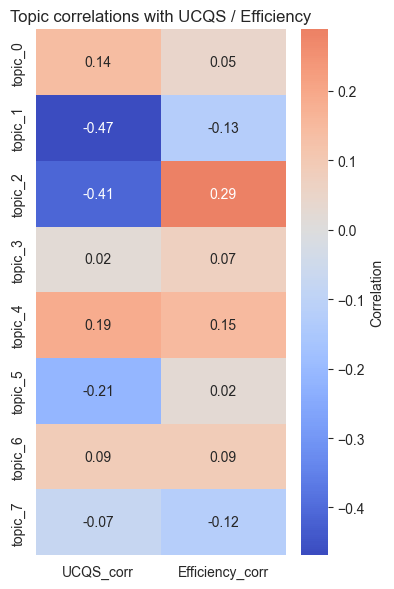

In [12]:
plt.figure(figsize=(4, 6))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Topic correlations with UCQS / Efficiency')
plt.tight_layout()
plt.show()


## Scatter: true vs predicted (Gradient Boosting)
Visual check of how well models fit UCQS and Efficiency. Efficiency uses the reduced feature set (engagement metrics removed).

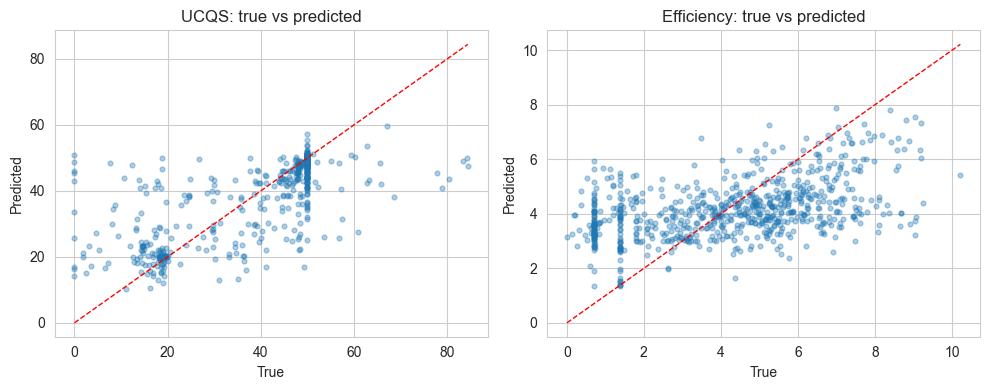

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, target, model in zip(axes, ['UCQS', 'Efficiency'], [model_ucqs, model_eff]):
    X_target = get_features_for(target)
    X_train, X_test, y_train, y_test = train_test_split(
        X_target, df[target], test_size=0.2, random_state=42
    )
    preds = model.predict(X_test)
    ax.scatter(y_test, preds, alpha=0.35, s=12)
    min_v = min(y_test.min(), preds.min())
    max_v = max(y_test.max(), preds.max())
    ax.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
    ax.set_title(f'{target}: true vs predicted')
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
plt.tight_layout()
plt.show()


## Boxplot: metrics by dominant topic
Distribution of UCQS/Efficiency grouped by the dominant topic (argmax of topic weights).

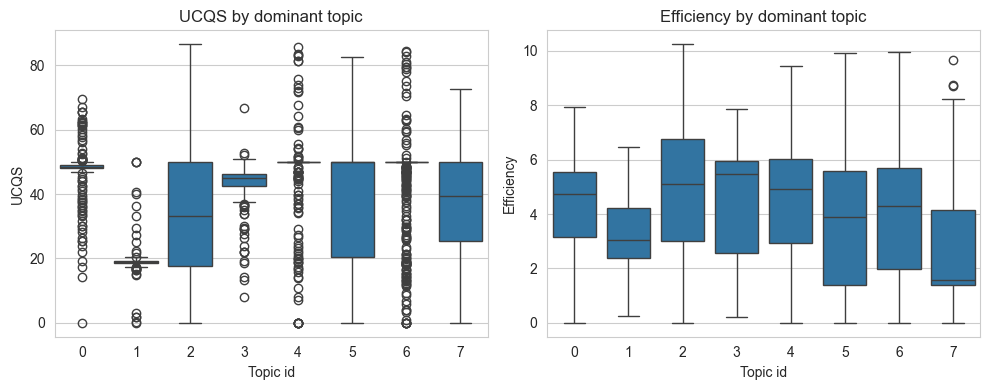

In [14]:
dominant = W_df.values.argmax(axis=1)
metrics_topics = pd.DataFrame({
    'dominant_topic': dominant,
    'UCQS': df['UCQS'].values,
    'Efficiency': df['Efficiency'].values,
})
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)
sns.boxplot(data=metrics_topics, x='dominant_topic', y='UCQS', ax=axes[0])
sns.boxplot(data=metrics_topics, x='dominant_topic', y='Efficiency', ax=axes[1])
axes[0].set_title('UCQS by dominant topic')
axes[1].set_title('Efficiency by dominant topic')
for ax in axes:
    ax.set_xlabel('Topic id')
plt.tight_layout()
plt.show()


## Positive vs negative n-grams (Spearman)
Side-by-side bars: n-grams with most negative and most positive Spearman correlations for both metrics.

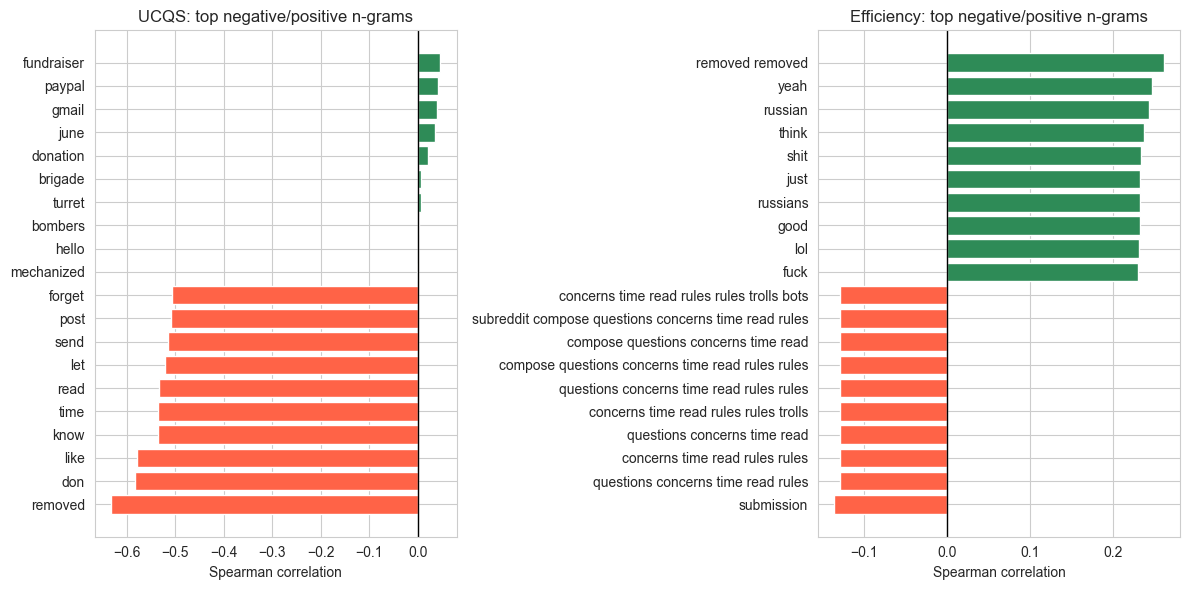

In [15]:
def plot_pos_neg(ax, corr_df, title, top=10):
    neg = corr_df.head(top)
    pos = corr_df.tail(top)
    subset = pd.concat([neg, pos]).sort_values('spearman')
    colors = ['tomato' if v < 0 else 'seagreen' for v in subset['spearman']]
    ax.barh(subset['ngram'], subset['spearman'], color=colors)
    ax.axvline(0, color='black', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel('Spearman correlation')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_pos_neg(axes[0], corr_ucqs, 'UCQS: top negative/positive n-grams')
plot_pos_neg(axes[1], corr_eff, 'Efficiency: top negative/positive n-grams')
plt.tight_layout()
plt.show()


## Boxplot: UCQS by dominant topic
Single-metric view to see which topics align with higher/lower UCQS (potentially “healthy” vs “toxic”).

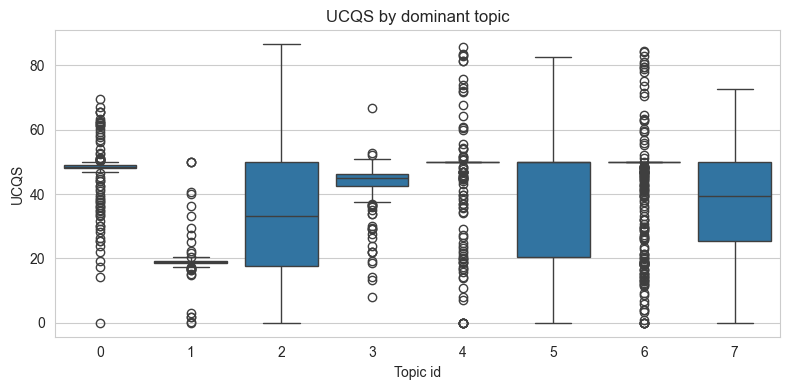

In [16]:
dominant = W_df.values.argmax(axis=1)
ucqs_by_topic = pd.DataFrame({'dominant_topic': dominant, 'UCQS': df['UCQS'].values})
plt.figure(figsize=(8, 4))
sns.boxplot(data=ucqs_by_topic, x='dominant_topic', y='UCQS')
plt.title('UCQS by dominant topic')
plt.xlabel('Topic id')
plt.ylabel('UCQS')
plt.tight_layout()
plt.show()
